In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from os.path import join
from os import getcwd
from IPython.display import clear_output

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.metrics import AUC # Area under the curve, default: ROC
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard
from keras.optimizers.schedules import ExponentialDecay
from keras.initializers import GlorotNormal
import kerastuner as kt

In [4]:
from functions import *

In [5]:
checkpoints_path = getcwd()+'\\checkpoints_A'
tensor_path = getcwd()+'\\tensor_A'

In [6]:
df = pd.read_csv('../../databases/diabetes.csv')
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
outlayers = {
    'BloodPressure': (40, np.Inf),
    'SkinThickness': (0, 80),
    'Insulin': (0, 400),
    'BMI': (0, 50)
}

zeros = [
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI'
]
x_df = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']]
y_df = df['Outcome']

In [8]:
# Split dataset into 15% test, 85% train 
x_temp, x_test, y_temp, y_test = train_test_split(x_df, y_df, test_size=0.15, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_temp, y_temp, test_size=0.15, random_state=1)

# Regresión Logistica

### Con los datos sin procesar

In [9]:
name = 'basic'
checkdir = join(checkpoints_path,name)
tensordir = join(tensor_path, name)

model_0 = Sequential()
model_0.add(Dense(units=1, activation='sigmoid', input_shape=(x_train.shape[1],)))
model_0.compile(optimizer=SGD(), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

In [10]:
model_0_checkpoint_callback = ModelCheckpoint(
    filepath=checkdir,
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True)

tensor_call = TensorBoard(log_dir=tensordir)

In [11]:
%%time
history = model_0.fit(x_train, y_train, epochs=50, 
            validation_data=(x_valid, y_valid),
            callbacks=[model_0_checkpoint_callback, tensor_call],
            verbose=0)
# Cargo el mejor modelo entrenado
model_0.load_weights(checkdir)
verify_model(model_0, x_train, y_train, x_valid, y_valid)

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Wall time: 9.1 s


,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.621374,0.753463,0.398964,0.463855,0.701031
1,Validacion,0.702665,0.812500,0.617647,0.636364,0.800000


### Reemplazando datos invalidos

In [12]:
x_train_nonzero, _data = replace_outliers_zeros(x_train, {}, zeros, mean_median=True)
x_test_nonzero, _data = replace_outliers_zeros(x_test, {}, zeros, mean_median=True, data_to_replace=_data)
x_valid_nonzero, _data = replace_outliers_zeros(x_valid, {}, zeros, mean_median=True, data_to_replace=_data)

In [13]:
name = 'valid'
checkdir = join(checkpoints_path, name)
tensordir = join(tensor_path, name)
tensor_call = TensorBoard(log_dir=tensordir)

model_1 = Sequential()
model_1.add(Dense(units=1, activation='sigmoid', input_shape=(x_train.shape[1],)))
model_1.compile(optimizer=SGD(), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

model_1_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                              save_weights_only=True,
                                              monitor='val_auc',
                                              mode='max',
                                              save_best_only=True)

In [14]:
%%time 
history = model_1.fit(x_train_nonzero, y_train, epochs=50, validation_data=(x_valid_nonzero, y_valid), callbacks=[model_1_checkpoint_callback, tensor_call], verbose=0)
# Cargo el mejor modelo entrenado
model_1.load_weights(checkdir)
verify_model(model_1, x_train_nonzero, y_train, x_valid_nonzero, y_valid)

Wall time: 11.1 s


,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.712292,0.698061,0.647668,0.534188,0.787500
1,Validacion,0.736213,0.718750,0.647059,0.550000,0.793103


Se puede observar como en ambos casos se obtuvo un mejor resultado en validacion que en train, lo cual es un comportamiento que se puede considerar poco esperado

### Reemplazando outlayers

In [15]:
x_train_clean, _data = replace_outliers_zeros(x_train, outlayers, zeros, mean_median=True)
x_test_clean, _data = replace_outliers_zeros(x_test, outlayers, zeros, mean_median=True, data_to_replace=_data)
x_valid_clean, _data = replace_outliers_zeros(x_valid, outlayers, zeros, mean_median=True, data_to_replace=_data)

In [16]:
name = 'sin_outlayers'
checkdir = join(checkpoints_path, name)
tensordir = join(tensor_path, name)
tensor_call = TensorBoard(log_dir=tensordir)

model_2 = Sequential()
model_2.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_clean.shape[1],)))
model_2.compile(optimizer=SGD(), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

model_2_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                              save_weights_only=True,
                                              monitor='val_auc',
                                              mode='max',
                                              save_best_only=True)

In [17]:
%%time 
history = model_2.fit(x_train_clean, y_train, epochs=50, validation_data=(x_valid_clean, y_valid), callbacks=[model_2_checkpoint_callback, tensor_call], verbose=0)
# Cargo el mejor modelo entrenado
model_2.load_weights(checkdir)
verify_model(model_2, x_train_clean, y_train, x_valid_clean, y_valid)

Wall time: 10.5 s


,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.706149,0.739612,0.621762,0.560748,0.785294
1,Validacion,0.743107,0.812500,0.588235,0.625000,0.787879


### Normalizando los datos de entrada

In [18]:
x_train_norm, _norm_dict = normalize(x_train_clean, None)
x_valid_norm, _norm_dict = normalize(x_valid_clean, _norm_dict)
x_test_norm, _norm_dict = normalize(x_test_clean, _norm_dict)

In [19]:
name = 'normalizado'
checkdir = join(checkpoints_path, name)
tensordir = join(tensor_path, name)
tensor_call = TensorBoard(log_dir=tensordir)

model_3 = Sequential()
model_3.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_norm.shape[1],)))
model_3.compile(optimizer=SGD(), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

model_3_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                              save_weights_only=True,
                                              monitor='val_auc',
                                              mode='max',
                                              save_best_only=True)

In [20]:
%%time 
history = model_3.fit(x_train_norm, y_train, epochs=100, validation_data=(x_valid_norm, y_valid), callbacks=[model_3_checkpoint_callback, tensor_call], verbose=1)
# Cargo el mejor modelo entrenado
model_3.load_weights(checkdir)
verify_model(model_3, x_train_norm, y_train, x_valid_norm, y_valid)

Epoch 1/100
18/18 [==============================] - 2s 95ms/step - loss: 1.2562 - auc: 0.1984 - val_loss: 1.1417 - val_auc: 0.2429
Epoch 2/100
18/18 [==============================] - 0s 22ms/step - loss: 1.1585 - auc: 0.2021 - val_loss: 1.0578 - val_auc: 0.2500
Epoch 3/100
18/18 [==============================] - 0s 25ms/step - loss: 1.0702 - auc: 0.2087 - val_loss: 0.9827 - val_auc: 0.2633
Epoch 4/100
18/18 [==============================] - 0s 20ms/step - loss: 0.9925 - auc: 0.2192 - val_loss: 0.9175 - val_auc: 0.2748
Epoch 5/100
18/18 [==============================] - 0s 19ms/step - loss: 0.9248 - auc: 0.2332 - val_loss: 0.8612 - val_auc: 0.2893
Epoch 6/100
18/18 [==============================] - 0s 21ms/step - loss: 0.8671 - auc: 0.2554 - val_loss: 0.8122 - val_auc: 0.3171
Epoch 7/100
18/18 [==============================] - 0s 16ms/step - loss: 0.8173 - auc: 0.2860 - val_loss: 0.7705 - val_auc: 0.3559
Epoch 8/100
18/18 [==============================] - 0s 15ms/step - loss: 0.

,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.834900,0.872576,0.585492,0.710692,0.797468
1,Validacion,0.825368,0.890625,0.470588,0.695652,0.760000


### Early Stopping
Los hyperparámetrso principales de este callback son:
- monitor: indica la variable a monitorear
- min_delta: la minima diferencia que se considera como mejora
- patience: cantidad de epochs sin mejoras antes de parar

In [21]:
stop_early = EarlyStopping(monitor='val_auc', patience=20)
name = 'early_stop'
checkdir = join(checkpoints_path, name)
tensordir = join(tensor_path, name)
tensor_call = TensorBoard(log_dir=tensordir)
model_4_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                              save_weights_only=True,
                                              monitor='val_auc',
                                              mode='max',
                                              save_best_only=True)

In [22]:
%%time 
history = model_3.fit(x_train_norm, y_train, epochs=50, validation_data=(x_valid_norm, y_valid), callbacks=[model_4_checkpoint_callback, stop_early, tensor_call], verbose=1)
# Cargo el mejor modelo entrenado
model_3.load_weights(checkdir)
verify_model(model_3, x_train_norm, y_train, x_valid_norm, y_valid)

Epoch 1/50
18/18 [==============================] - 1s 65ms/step - loss: 0.4780 - auc: 0.8349 - val_loss: 0.4807 - val_auc: 0.8258
Epoch 2/50
18/18 [==============================] - 0s 8ms/step - loss: 0.4779 - auc: 0.8349 - val_loss: 0.4804 - val_auc: 0.8258
Epoch 3/50
18/18 [==============================] - 0s 10ms/step - loss: 0.4778 - auc: 0.8351 - val_loss: 0.4803 - val_auc: 0.8256
Epoch 4/50
18/18 [==============================] - 0s 9ms/step - loss: 0.4777 - auc: 0.8350 - val_loss: 0.4801 - val_auc: 0.8254
Epoch 5/50
18/18 [==============================] - 0s 8ms/step - loss: 0.4776 - auc: 0.8348 - val_loss: 0.4798 - val_auc: 0.8258
Epoch 6/50
18/18 [==============================] - 0s 12ms/step - loss: 0.4775 - auc: 0.8353 - val_loss: 0.4798 - val_auc: 0.8258
Epoch 7/50
18/18 [==============================] - 0s 18ms/step - loss: 0.4774 - auc: 0.8351 - val_loss: 0.4796 - val_auc: 0.8261
Epoch 8/50
18/18 [==============================] - 0s 5ms/step - loss: 0.4773 - auc: 

,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.836063,0.869806,0.580311,0.704403,0.794937
1,Validacion,0.826746,0.906250,0.470588,0.727273,0.763158


Se puede evidenciar como al utilizar early stopping el entrenamiento finaliza antes debido a que las mejoras son reducidas

## Ajuste de Hyperparámetros

### Learning rate
Por defecto en SGD el learning rate que utiliza keras es 0.01

In [23]:
learning_rates = [1e-5, 1e-4, 1e-3, 0.01, 0.05, 0.1, 0.22, 0.33, 0.47, 0.56, 0.81, 1.2, 1.8, 2.2, 2.7, 3.3, 4.7]

arr_of_metrics = []
auc_res = {'L_r':['AUC', 'Epochs']}
best = 0
best_name = ''
for i in learning_rates:
    name = 'learning_{}'.format(i)
    checkdir = join(checkpoints_path, name)
    tensordir = join(tensor_path, name)
    tensor_call = TensorBoard(log_dir=tensordir)
    learning_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)


    learning = Sequential()
    learning.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_norm.shape[1],)))
    learning.compile(optimizer=SGD(learning_rate=i), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

    history = learning.fit(x_train_norm, y_train, epochs=100, validation_data=(x_valid_norm, y_valid), callbacks=[learning_checkpoint_callback, stop_early, tensor_call], 
                          verbose=1)
    # Cargo el mejor modelo entrenado
    learning.load_weights(checkdir)
    metrics = verify_model(learning, x_train_norm, y_train, x_valid_norm, y_valid)
    arr_of_metrics.append(metrics)
    auc_res[i] = [metrics['AUC ROC'][1], history.epoch[-1]]
    if best < auc_res[i][0]:
        best_name = checkdir
        best = auc_res[i][0]
    clear_output(wait=True)
pd.DataFrame(data=auc_res)

,L_r,1e-05,0.0001,0.001,0.01,0.05,0.1,0.22,0.33,0.47,0.56,0.81,1.2,1.8,2.2,2.7,3.3,4.7
0,AUC,0.461397,0.328125,0.606158,0.668199,0.836857,0.829504,0.83364,0.835478,0.832721,0.840533,0.846507,0.84375,0.842831,0.850184,0.849265,0.847886,0.841452
1,Epochs,30.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,23.000000,40.000000,44.00000,32.000000,29.000000,23.000000,35.000000,20.000000


Es interesante observar como para los learning rate mas chicos, el entrenamiento se corta debido al early stoping en los primeros 15 epochs, ya que dentro de esos primeros 15 las mejoras son pocas debido a su avance "suave", en comparación con los learning rates mas altos que obtienen una mejor optimización en mayor cantidad de epochs

In [24]:
# Cargo el mejor modelo entrenado
learning.load_weights(best_name)
verify_model(learning, x_train_norm, y_train, x_valid_norm, y_valid)

,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.803511,0.878116,0.544041,0.704698,0.782716
1,Validacion,0.850184,0.859375,0.500000,0.653846,0.763889


#### Scheduling learning rate

In [25]:
learning_schedule = ExponentialDecay(initial_learning_rate=2.7, decay_steps=100, decay_rate=0.96)
name = 'exponetial'
checkdir = join(checkpoints_path, name)
tensordir = join(tensor_path, name)
tensor_call = TensorBoard(log_dir=tensordir)
    
exponential_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)


In [26]:
learning = Sequential()
learning.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_norm.shape[1],)))
learning.compile(optimizer=SGD(learning_rate=learning_schedule), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

In [27]:
history = learning.fit(x_train_norm, y_train, epochs=100, validation_data=(x_valid_norm, y_valid), callbacks=[exponential_checkpoint_callback, stop_early, tensor_call], 
                      verbose=1)
# Cargo el mejor modelo entrenado
learning.load_weights(checkdir)
verify_model(learning, x_train_norm, y_train, x_valid_norm, y_valid)

Epoch 1/100
18/18 [==============================] - 2s 94ms/step - loss: 0.5665 - auc: 0.7716 - val_loss: 0.5172 - val_auc: 0.8169
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.5276 - auc: 0.8016 - val_loss: 0.5029 - val_auc: 0.8038
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.5163 - auc: 0.8091 - val_loss: 0.5128 - val_auc: 0.8028
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.5215 - auc: 0.8055 - val_loss: 0.5301 - val_auc: 0.7865
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 0.5255 - auc: 0.8089 - val_loss: 0.6183 - val_auc: 0.7385
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.5409 - auc: 0.7941 - val_loss: 0.5768 - val_auc: 0.7279
Epoch 7/100
18/18 [==============================] - 0s 19ms/step - loss: 0.5187 - auc: 0.8012 - val_loss: 0.5052 - val_auc: 0.8433
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.5218 

,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.814677,0.844875,0.601036,0.674419,0.798429
1,Validacion,0.842831,0.875000,0.617647,0.724138,0.811594


### Momentum

In [28]:
momentum_arr = [0.5, 0.6, 0.85, 0.9, 0.95, 0.99, 0.999]

arr_of_metrics = []
auc_res = {'momentum':['AUC', 'Epochs']}
for i in momentum_arr:
    name = 'momentum_{}'.format(i)
    checkdir = join(checkpoints_path, name)
    tensordir = join(tensor_path, name)
    tensor_call = TensorBoard(log_dir=tensordir)

    momentum_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)
    
    mom_model = Sequential()
    mom_model.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_norm.shape[1],)))
    mom_model.compile(optimizer=SGD(learning_rate=learning_schedule, momentum=i), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

    history = mom_model.fit(x_train_norm, y_train, epochs=100, validation_data=(x_valid_norm, y_valid), callbacks=[momentum_checkpoint_callback, tensor_call], 
                          verbose=1)
    # Cargo el mejor modelo entrenado
    mom_model.load_weights(checkdir)
    metrics = verify_model(mom_model, x_train_norm, y_train, x_valid_norm, y_valid)
    arr_of_metrics.append(metrics)
    auc_res[i] = [metrics['AUC ROC'][1], history.epoch[-1]]
    clear_output(wait=True)
pd.DataFrame(data=auc_res)

,momentum,0.5,0.6,0.85,0.9,0.95,0.99,0.999
0,AUC,0.851103,0.84421,0.840074,0.84421,0.837776,0.809972,0.769761
1,Epochs,99.000000,99.00000,99.000000,99.00000,99.000000,99.000000,99.000000


In [29]:
name = 'momentum'
checkdir = join(checkpoints_path, name)
tensordir = join(tensor_path, name)
tensor_call = TensorBoard(log_dir=tensordir)
momentum_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)

mom_model = Sequential()
mom_model.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_norm.shape[1],)))
mom_model.compile(optimizer=SGD(learning_rate=learning_schedule, momentum=0.6), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
history = mom_model.fit(x_train_norm, y_train, epochs=100, validation_data=(x_valid_norm, y_valid), callbacks=[momentum_checkpoint_callback, stop_early, tensor_call], 
                          verbose=1)
# Cargo el mejor modelo entrenado
mom_model.load_weights(checkdir)
verify_model(mom_model, x_train_norm, y_train, x_valid_norm, y_valid)

Epoch 1/100
18/18 [==============================] - 3s 156ms/step - loss: 0.5802 - auc: 0.7835 - val_loss: 0.6617 - val_auc: 0.7553
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.6116 - auc: 0.7790 - val_loss: 0.6057 - val_auc: 0.7378
Epoch 3/100
18/18 [==============================] - 0s 20ms/step - loss: 0.5798 - auc: 0.7850 - val_loss: 0.6375 - val_auc: 0.8035
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.6498 - auc: 0.7699 - val_loss: 0.7918 - val_auc: 0.5935
Epoch 5/100
18/18 [==============================] - 0s 21ms/step - loss: 0.6169 - auc: 0.7718 - val_loss: 0.4840 - val_auc: 0.8217
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.6029 - auc: 0.7794 - val_loss: 0.6742 - val_auc: 0.6719
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6202 - auc: 0.7690 - val_loss: 0.5496 - val_auc: 0.7838
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.585

,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.811850,0.817175,0.626943,0.647059,0.803815
1,Validacion,0.836397,0.843750,0.676471,0.696970,0.830769


### Optimizador Adam

In [30]:
%%time
adam_lr = [1e-5, 1e-4, 1e-3, 0.01, 0.05, 0.1, 0.22, 0.33, 0.47, 0.56, 0.81, 1.2, 1.8, 2.2, 2.7, 3.3, 4.7]

arr_of_metrics = []
auc_res = {'L_r':['AUC', 'Epochs']}
for i in adam_lr:
    name = 'Adam_{}'.format(i)
    checkdir = join(checkpoints_path, name)
    tensordir = join(tensor_path, name)
    tensor_call = TensorBoard(log_dir=tensordir)
    adam_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)
    adam_mod = Sequential()
    adam_mod.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_norm.shape[1],)))
    adam_mod.compile(optimizer=Adam(learning_rate=i), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

    history = adam_mod.fit(x_train_norm, y_train, epochs=100, validation_data=(x_valid_norm, y_valid), callbacks=[adam_checkpoint_callback, tensor_call], 
                          verbose=1, use_multiprocessing=True)
    # Cargo el mejor modelo entrenado
    adam_mod.load_weights(checkdir)
    metrics = verify_model(adam_mod, x_train_norm, y_train, x_valid_norm, y_valid)
    arr_of_metrics.append(metrics)
    auc_res[i] = [metrics['AUC ROC'][1], history.epoch[-1]]
    clear_output(wait=True)
pd.DataFrame(data=auc_res)

Wall time: 5min 42s


,L_r,1e-05,0.0001,0.001,0.01,0.05,0.1,0.22,0.33,0.47,0.56,0.81,1.2,1.8,2.2,2.7,3.3,4.7
0,AUC,0.349265,0.542739,0.82261,0.832261,0.837776,0.842371,0.84375,0.847426,0.848346,0.848346,0.84329,0.846048,0.839614,0.837776,0.828585,0.84375,0.824908
1,Epochs,99.000000,99.000000,99.00000,99.000000,99.000000,99.000000,99.00000,99.000000,99.000000,99.000000,99.00000,99.000000,99.000000,99.000000,99.000000,99.00000,99.000000


In [31]:
%%time
name = 'Adam'
checkdir = join(checkpoints_path, name)
tensordir = join(tensor_path, name)
tensor_call = TensorBoard(log_dir=tensordir)
adam_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)

adam_model = Sequential()
adam_model.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_norm.shape[1],)))
adam_model.compile(optimizer=Adam(learning_rate=4.7), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
history = adam_model.fit(x_train_norm, y_train, epochs=100, validation_data=(x_valid_norm, y_valid), callbacks=[adam_checkpoint_callback, tensor_call], 
                          verbose=1)
# Cargo el mejor modelo entrenado
adam_model.load_weights(checkdir)
verify_model(adam_model, x_train_norm, y_train, x_valid_norm, y_valid)

Epoch 1/100
18/18 [==============================] - 1s 82ms/step - loss: 2.5737 - auc: 0.6936 - val_loss: 2.1725 - val_auc: 0.6675
Epoch 2/100
18/18 [==============================] - 0s 18ms/step - loss: 2.3818 - auc: 0.6853 - val_loss: 1.9679 - val_auc: 0.7489
Epoch 3/100
18/18 [==============================] - 0s 12ms/step - loss: 2.2700 - auc: 0.7005 - val_loss: 1.5579 - val_auc: 0.6818
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 2.2543 - auc: 0.6800 - val_loss: 1.1141 - val_auc: 0.7213
Epoch 5/100
18/18 [==============================] - 0s 18ms/step - loss: 1.6742 - auc: 0.7103 - val_loss: 0.8751 - val_auc: 0.7939
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 1.8076 - auc: 0.6721 - val_loss: 1.4543 - val_auc: 0.7592
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 1.8455 - auc: 0.6857 - val_loss: 1.3927 - val_auc: 0.7369
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 2.5500

,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.795193,0.850416,0.549223,0.6625,0.779188
1,Validacion,0.838235,0.859375,0.617647,0.7000,0.808824


Evaluación contra test

In [32]:
print('Utilizando SGD')
verify_model(mom_model, x_train_norm, y_train, x_test_norm, y_test, valid_label='Test')

Utilizando SGD


,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.811850,0.817175,0.626943,0.647059,0.803815
1,Test,0.832846,0.840000,0.707317,0.707317,0.840000


In [33]:
print('Utilizando Adam')
verify_model(adam_model, x_train_norm, y_train, x_test_norm, y_test, valid_label='Test')

Utilizando Adam


,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.795193,0.850416,0.549223,0.6625,0.779188
1,Test,0.830894,0.826667,0.658537,0.6750,0.815789


Finalmente se obtiene que el modelo que utiliza como optimizador SGD y los hyperparámetros optimizados fue el mejor de los entrenados hasta ahora

Cabe destacar una particularidad, que los resustados en Test son mejores que en el set de validacion, e incluso mejores que el set de train, con lo cual concluir que la metrica de nuestro modelo es AUC=0.86 no sería correcto, ya que es el caso en el que tenemos un estimador con alta varianza, por lo tanto una estimación utilizando k-folding sería mas adecuada (si hay tiempo la hago...)

In [34]:
def f2_threshold_b(my_model, x_train, y_train, x_validation, y_validation):
    y_train_pred = my_model.predict(x_train)
    y_valid_pred = my_model.predict(x_validation)
    th = np.linspace(0, 1, 100)
    f2score_v = []
    f2score_t = []
    max_f = [0, 0]
    for t in th:
        y_pred_t = (y_train_pred > t).astype(int)
        y_pred_v = (y_valid_pred > t).astype(int)
        score_t = fbeta_score(y_train, y_pred_t, beta=2)
        score_v = fbeta_score(y_validation, y_pred_v, beta=2)
        f2score_t.append(score_t)
        f2score_v.append(score_v)
        if score_v > max_f[0]:
            max_f[0] = score_v
            max_f[1] = t
    
    print('Best threshold : {}'.format(max_f[1]))
    plt.plot(th, f2score_t, label='train')
    plt.plot(th, f2score_v, label='valid')
    
    plt.xlabel('Threshold')
    plt.ylabel('F2 score')
    
    plt.axvline(max_f[1], color='black', linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid()
    plt.legend()
    plt.show()

Best threshold : 0.12121212121212122


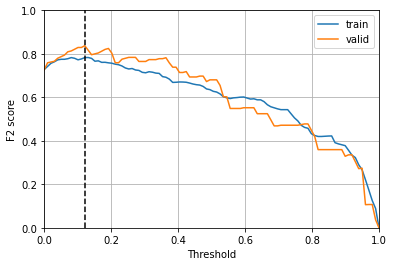

In [35]:
f2_threshold_b(mom_model, x_train_norm, y_train, x_valid_norm, y_valid)